# COVID-19 Project - Predict Death - Using scikit-learn Pipeline

## 1. Importing libraries


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

import joblib, dill

## 2. Data loading and first impressions

In [46]:
df = pd.read_csv('/kaggle/input/covid19-dataset/Covid Data.csv')
df.head(3)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2


In [47]:
df.tail(3)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97
1048574,2,13,2,1,9999-99-99,97,2,52,97,2,...,2,2,2,2,2,2,2,2,7,97


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [49]:
df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


In [50]:
df.isnull().sum().sum()

0

In [51]:
df.corr(numeric_only=True)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
USMER,1.000000,0.127927,-0.001126,-0.190570,0.175457,-0.154950,-0.045088,-0.001469,0.014704,0.011030,0.010814,0.003234,0.014830,-0.015763,0.010097,0.014567,0.011527,0.010638,0.028840,0.174901
MEDICAL_UNIT,0.127927,1.000000,0.001475,-0.205413,0.205243,-0.046433,-0.082223,0.005300,0.019523,0.014209,0.013312,0.011785,0.020964,0.027453,0.014406,0.019577,0.014751,0.012282,0.079981,0.205141
SEX,-0.001126,0.001475,1.000000,0.089505,-0.089943,-0.012131,0.028367,0.992713,0.008888,0.009372,0.010415,0.007999,0.009257,0.009039,0.008174,0.009858,0.008249,0.004919,-0.057782,-0.089844
PATIENT_TYPE,-0.190570,-0.205413,0.089505,1.000000,-0.976335,0.022966,0.315193,0.088340,0.008743,0.019548,0.023042,0.024924,0.006852,0.036724,0.022175,0.019650,0.018873,0.022123,-0.183370,-0.975810
INTUBED,0.175457,0.205243,-0.089943,-0.976335,1.000000,0.079743,-0.317945,-0.088097,-0.009215,-0.020124,-0.023446,-0.024140,-0.007628,-0.035404,-0.022442,-0.020217,-0.019309,-0.022428,0.193075,0.999434
PNEUMONIA,-0.154950,-0.046433,-0.012131,0.022966,0.079743,1.000000,-0.073127,-0.007284,-0.004484,-0.005618,-0.005392,-0.000802,-0.004799,0.001612,-0.004758,-0.004276,-0.005287,-0.004325,0.075351,0.079691
AGE,-0.045088,-0.082223,0.028367,0.315193,-0.317945,-0.073127,1.000000,0.027257,0.004422,0.019048,0.022715,0.022820,-0.004964,0.022837,0.019489,0.015500,0.020124,0.021263,-0.152637,-0.317813
PREGNANT,-0.001469,0.005300,0.992713,0.088340,-0.088097,-0.007284,0.027257,1.000000,0.014707,0.015736,0.016765,0.014265,0.015335,0.014175,0.014378,0.015895,0.014392,0.010794,-0.057809,-0.087991
DIABETES,0.014704,0.019523,0.008888,0.008743,-0.009215,-0.004484,0.004422,0.014707,1.000000,0.828823,0.829349,0.781108,0.835018,0.634611,0.809417,0.752739,0.812657,0.771763,-0.004739,-0.009223
COPD,0.011030,0.014209,0.009372,0.019548,-0.020124,-0.005618,0.019048,0.015736,0.828823,1.000000,0.908929,0.852273,0.855249,0.687323,0.880097,0.814868,0.884032,0.836097,-0.010336,-0.020146


In [52]:
df.duplicated().sum() # We'll remove the duplicates in pipeline. (Best-Practice for frequently updated datasets)

812049

# 3. Exploratory Data Analysis

In [53]:
# As per dataset, 97, 98, 99 are missing values.
missing_data = {}
for i in df:
    missing_data[i] = ((df[i] == 97).sum()+ (df[i] == 99).sum())/df.shape[0]*100
print(pd.DataFrame([missing_data]).T)

                              0
USMER                  0.000000
MEDICAL_UNIT           0.000000
SEX                    0.000000
PATIENT_TYPE           0.000000
DATE_DIED              0.000000
INTUBED               81.622106
PNEUMONIA              1.526166
AGE                    0.021076
PREGNANT              49.925947
DIABETES               0.000000
COPD                   0.000000
ASTHMA                 0.000000
INMSUPR                0.000000
HIPERTENSION           0.000000
OTHER_DISEASE          0.000000
CARDIOVASCULAR         0.000000
OBESITY                0.000000
RENAL_CHRONIC          0.000000
TOBACCO                0.000000
CLASIFFICATION_FINAL   0.000000
ICU                   81.637651


In [54]:
# Now lets see for actual missing data:  (We'll handle this in pipeline using imputer)
missing_data = {}
for i in df:
    missing_data[i] = ((df[i] == 98).sum())/df.shape[0]*100
print(pd.DataFrame([missing_data]).T)

                             0
USMER                 0.000000
MEDICAL_UNIT          0.000000
SEX                   0.000000
PATIENT_TYPE          0.000000
DATE_DIED             0.000000
INTUBED               0.000000
PNEUMONIA             0.000000
AGE                   0.011826
PREGNANT              0.358010
DIABETES              0.318337
COPD                  0.286389
ASTHMA                0.284100
INMSUPR               0.324631
HIPERTENSION          0.296021
OTHER_DISEASE         0.481129
CARDIOVASCULAR        0.293350
OBESITY               0.289154
RENAL_CHRONIC         0.286675
TOBACCO               0.307083
CLASIFFICATION_FINAL  0.000000
ICU                   0.000000


In [55]:
# Values 1-3 mean that the patient was diagnosed with covid in different degrees. 
# 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
# So, we'll convert 4, 5, 6, 7 to 0 as patient does not have COVID.
df['CLASIFFICATION_FINAL'].value_counts() 

CLASIFFICATION_FINAL
7    499250
3    381527
6    128133
5     26091
1      8601
4      3122
2      1851
Name: count, dtype: int64

In [56]:
# As per dataset, if DATE_DIED = 9999-99-99 then patient is alive else dead.
# So we'll convert this feature to Alive or Dead in pipeline.
df['DATE_DIED'].value_counts()

DATE_DIED
9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: count, Length: 401, dtype: int64

In [57]:
df['AGE'].min(), df['AGE'].max()  # Age is between 0 and 121. We'll scale this in pipeline.

(0, 121)

In [58]:
df['MEDICAL_UNIT'].value_counts() 
# MEDICAL_UNIT is nothing but the type of institution of the National Health System that provided care. 
# We'll encode this using one-hot encoder in pipeline.

MEDICAL_UNIT
12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: count, dtype: int64

In [59]:
# Finally, we'll check if there's any 97, 98, 99 value present in dataset (except AGE feature).
# If it is then we'll fill it with np.nan.
# Then we'll use iterative imputer to fill missing values appropreatly.

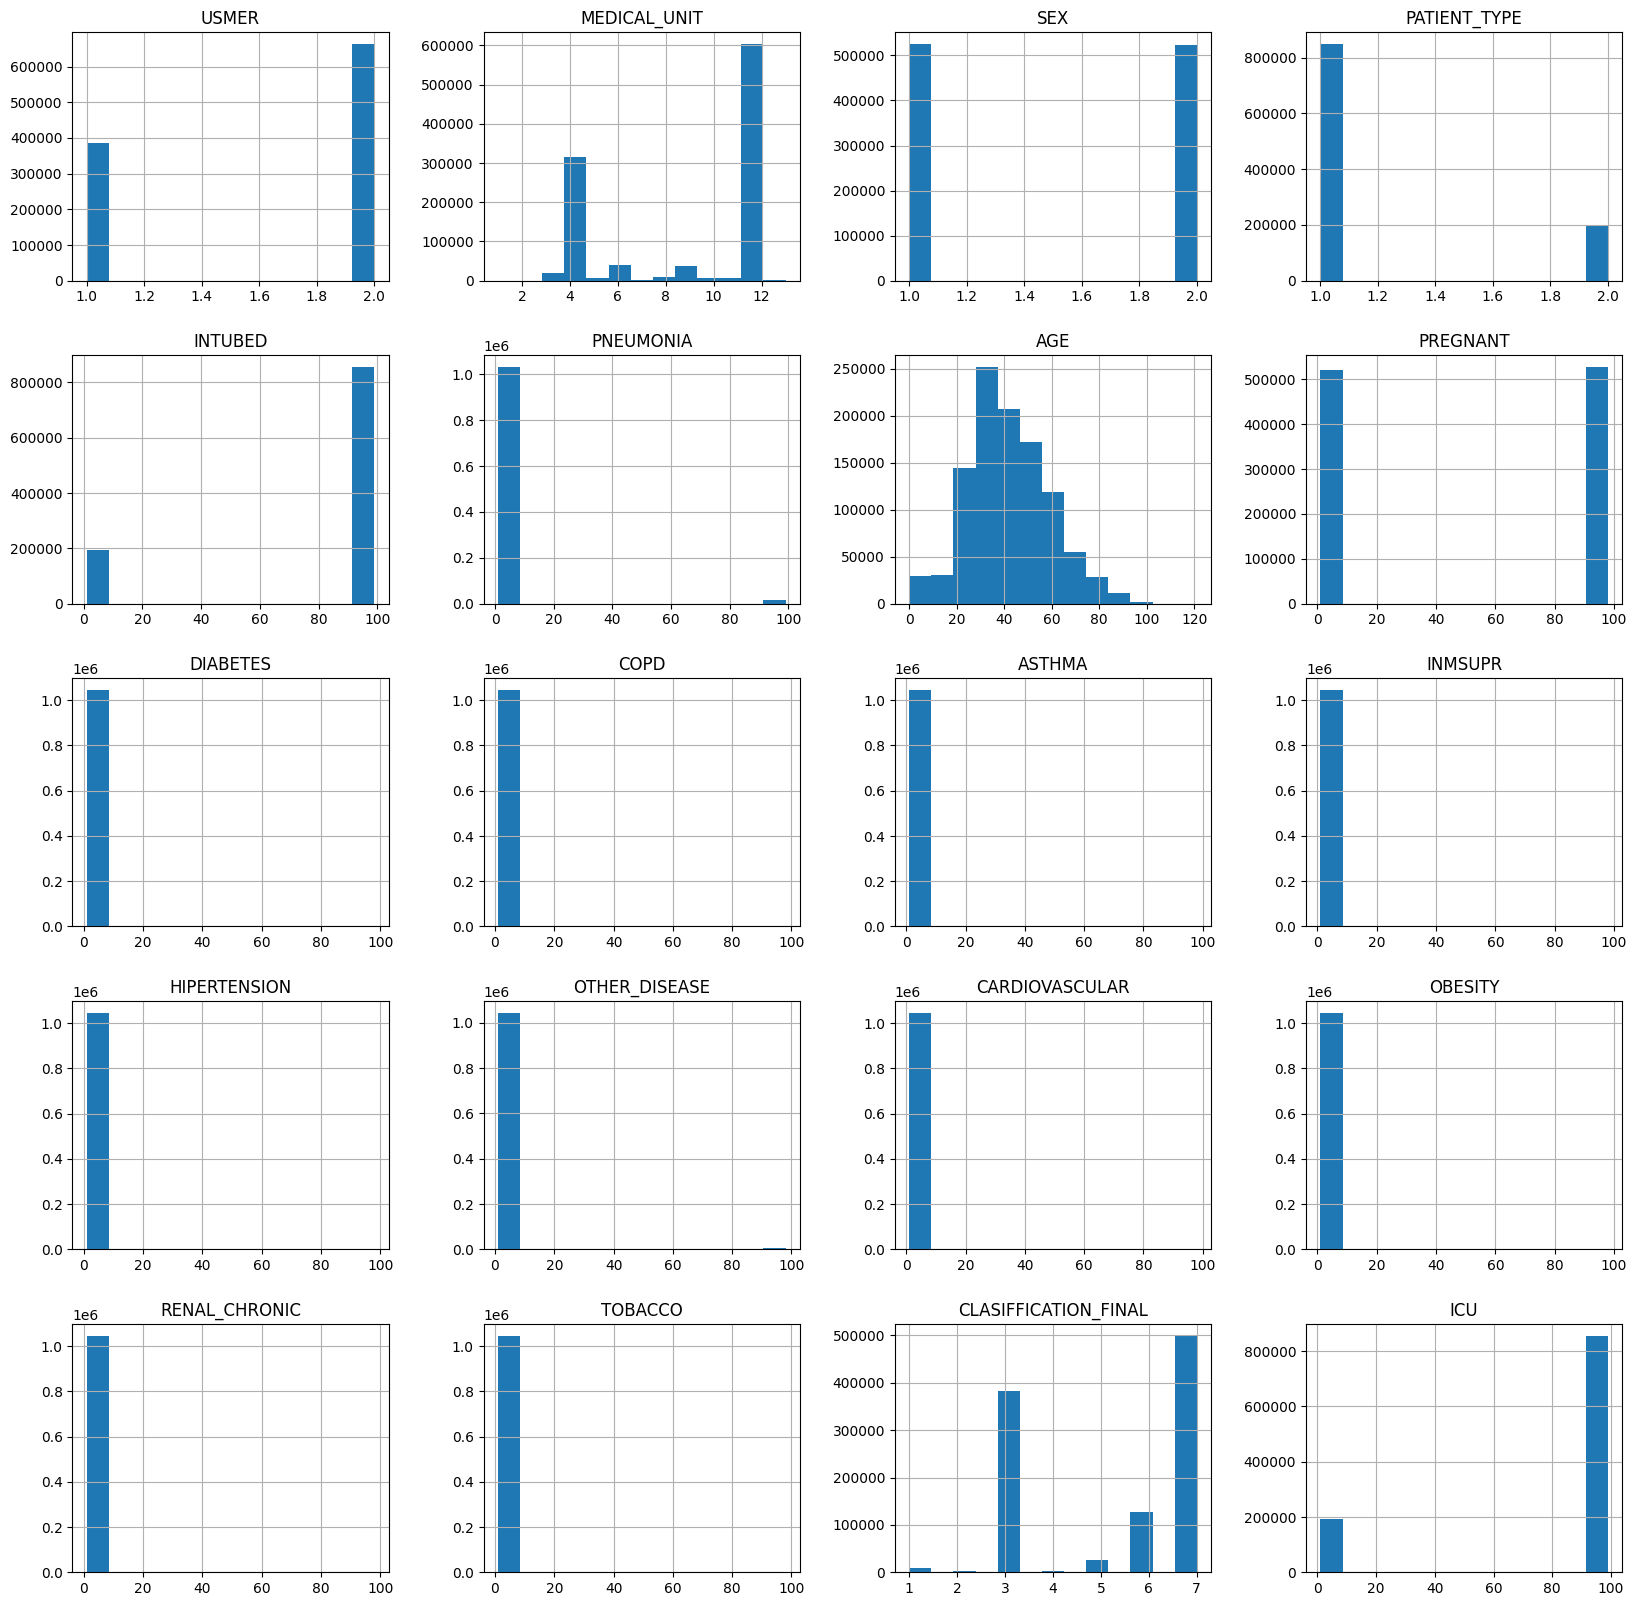

In [60]:
df.hist(figsize=(20,20),bins=13);  # Provides insight to unique values and rough count per feature.

## 4. Custom Transformers

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin


class DuplicatesRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if y is not None and X.index.equals(y.index):
            X_y = pd.concat([X, y], axis=1)
            self.unique_indices = X_y.drop_duplicates().index
        print('1. \tDuplicatesRemover fitted')
        self.fitted_ = True
        return self

    def transform(self, X, y=None):
        if y is not None and X.index.equals(y.index):
            X_transformed = X.loc[self.unique_indices]
            y_transformed = y.loc[self.unique_indices]
            print("Transform - X shape:", X_transformed.shape)
            print("Transform - y shape:", y_transformed.shape)
            return X_transformed, y_transformed
            print('1. \tDuplicatesRemover transform')
        print('1. \tDuplicatesRemover transform')
        return X  # Simply pass X through if no y

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)


    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)
    #     return self.transform(X)

class SpecificFeaturesConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        print('2. \tSpecificFeaturesConverter fitted')
        self.fitted_ = True
        return self

    def transform(self, X, y=None):
        X = X.copy() if not isinstance(X, tuple) else X[0]
        print('X shape = ', X.shape)
        X['CLASIFFICATION_FINAL'] = X['CLASIFFICATION_FINAL'].apply(lambda x: 0 if x > 3 else x)
        X.loc[X['SEX'] == 2, 'PREGNANT'] = 0
        X.loc[X['PATIENT_TYPE'] == 1, 'ICU'] = 0
        X.loc[X['PATIENT_TYPE'] == 1, 'INTUBED'] = 0
        print('2. \tSpecificFeaturesConverter transform')
        if y is not None:
            return X, y
        return X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)


    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform

class PlaceholderReplacer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass

    def fit(self, X, y=None):
        print('3. \tPlaceholderReplacer fitted')
        self.fitted_ = True
        return self

    def transform(self, X):
        X = X.copy() if not isinstance(X, tuple) else X[0]
        print('X shape = ', X.shape)
        cols_to_convert = X.columns[X.columns != 'AGE']
        X.loc[:, X.columns != 'AGE'] = X.loc[:, X.columns != 'AGE'].astype(float)
        X[cols_to_convert] = X[cols_to_convert].astype(float)
        X[cols_to_convert] = X[cols_to_convert].replace([97, 98, 99], np.nan)
        print('3. \tPlaceholderReplacer transform')
        return pd.DataFrame(X)

    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform

class BinaryConverter(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass

    def fit(self, X, y=None):
        print('4. \tBinaryConverter fitted')
        self.fitted_ = True
        return self

    def transform(self, X):
        X = X.copy() if not isinstance(X, tuple) else X[0]
        print('X shape = ', X.shape)
        for col in X.columns:
            if col != 'AGE':
                if X[col].dtype == 'int64' or X[col].dtype == 'float64':
                    X[col] = X[col].astype(float)  # Explicitly cast to float for compatibility
                    X[col] = X[col].replace(2, 0)
                    X[col] = X[col].replace([97, 98, 99], np.nan)
        # X.loc[:, X.columns != 'AGE'] = X.loc[:, X.columns != 'AGE'].replace(2, 0)
        # X.loc[:, X.columns != 'AGE'] = X.loc[:, X.columns != 'AGE'].replace([97, 98, 99], np.nan)
        print('4. \tBinaryConverter transform')
        return pd.DataFrame(X)

    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform
        
class MinMaxScaler_own(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.scaled_columns = None
        
    def fit(self, X, y=None):
        self.scaler.fit(X)
        self.scaled_columns = X.columns  # Store the original column names
        print('5.1. \tMinMaxScaler_own fitted')
        self.fitted_ = True
        return self

    def transform(self, X):
        print('X shape = ', X.shape)
        scaled_data = self.scaler.transform(X)
        scaled_data = pd.DataFrame(scaled_data, columns=self.scaled_columns, index=X.index)
        print('5.1. \t(Num features) MinMaxScaler_own transform')
        scaled_data.head(1)
        return scaled_data


    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform

class IterativeImputer_num_own(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass

    def fit(self, X, y=None):
        print('5.1.1. \tIterativeImputer_num_own fitted')
        self.fitted_ = True
        return self

    def transform(self, X):
        X = X.copy() if not isinstance(X, tuple) else X[0]
        print('X shape = ', X.shape)
        impute_num_cols = X.columns
        cols_to_convert = X.columns[X.columns != 'AGE']
        X[cols_to_convert] = X[cols_to_convert].astype(float)
        X[cols_to_convert] = X[cols_to_convert].replace([97, 98, 99], np.nan)
        print('5.1.1 \t(Num features) IterativeImputer_num_own transform')
        pd.DataFrame(X, columns = impute_num_cols).head(1)
        return pd.DataFrame(X, columns = impute_num_cols)

    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform

# class OneHotEncoderWithNames(BaseEstimator, TransformerMixin):
#     def __init__(self, drop=None, sparse_output=False, handle_unknown='ignore'):
#         self.drop = drop
#         self.sparse_output = sparse_output
#         self.handle_unknown = handle_unknown
#         self.encoded_columns = None
#         self.encoder = OneHotEncoder(drop=self.drop, sparse_output=self.sparse_output, handle_unknown=self.handle_unknown)

#     def fit(self, X, y=None):
#         self.encoder.fit(X)
#         self.encoded_columns = self.encoder.get_feature_names_out(X.columns)
#         print('5.2. \tOneHotEncoderWithNames fitted')
#         self.fitted_ = True
#         return self

#     def transform(self, X):
#         check_is_fitted(self, 'fitted_')
#         encoded_data = self.encoder.transform(X)
#         if hasattr(encoded_data, "toarray"):
#             encoded_data = encoded_data.toarray()
#         encoded_df = pd.DataFrame(encoded_data, columns=self.encoded_columns, index=X.index)
#         print('5.2. \t(Cat features) OneHotEncoderWithNames transform')
#         return encoded_df

class OneHotEncoderWithNames(BaseEstimator, TransformerMixin):
    def __init__(self, drop=None, sparse_output=False, handle_unknown='ignore'):
        self.drop = drop
        self.sparse_output = sparse_output
        self.handle_unknown = handle_unknown
        self.encoded_columns = None
        self.encoder = OneHotEncoder(drop=self.drop, sparse_output=self.sparse_output, handle_unknown=self.handle_unknown)

    def fit(self, X, y=None):
        self.encoder.fit(X)
        self.encoded_columns = self.encoder.get_feature_names_out(X.columns)
        print('5.2. \tOneHotEncoderWithNames fitted')
        self.fitted_ = True
        return self

    def transform(self, X):
        check_is_fitted(self, 'fitted_')
        unknown_category_warnings = []

        for col in X.columns:
            unique_categories = set(X[col].unique()) - set(self.encoder.categories_[0])
            if unique_categories:
                unknown_category_warnings.append((col, unique_categories))
        
        if unknown_category_warnings:
            print("Unknown categories found during transform: ", unknown_category_warnings)

        encoded_data = self.encoder.transform(X)
        if hasattr(encoded_data, "toarray"):
            encoded_data = encoded_data.toarray()
        encoded_df = pd.DataFrame(encoded_data, columns=self.encoded_columns, index=X.index)
        print('5.2. \t(Cat features) OneHotEncoderWithNames transform')
        return encoded_df


    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform

class IterativeImputer_cat_own(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass

    def fit(self, X, y=None):
        print('5.2.1. \tIterativeImputer_cat_own fitted')
        self.fitted_ = True
        return self

    def transform(self, X):
        X = X.copy() if not isinstance(X, tuple) else X[0]
        print('X shape = ', X.shape)
        impute_cat_cols = X.columns
        cols_to_convert = X.columns[X.columns != 'AGE']
        X[cols_to_convert] = X[cols_to_convert].astype(float)
        X[cols_to_convert] = X[cols_to_convert].replace([97, 98, 99], np.nan)
        print('5.2.1 \t(Cat features) IterativeImputer_cat_own transform')
        return pd.DataFrame(X, columns = impute_cat_cols)

    # def fit_transform(self, X, y=None):
    #     self.fit(X, y)  # Fit first
    #     return self.transform(X)  # Then transform

## 5. Data Preprocessing Pipeline

In [62]:
# Define cat_features and num_features before the train_test_split ***
cat_features = ['MEDICAL_UNIT', 'CLASIFFICATION_FINAL']
num_features = df.columns.difference(cat_features + ['DATE_DIED']).tolist()

num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler_own()),
    ('imputer', IterativeImputer_num_own())
])

cat_transformer = Pipeline(steps=[
    # ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ('encoder', OneHotEncoderWithNames(drop='first', sparse_output=False, handle_unknown='ignore')), # Use custom encoder
    ('imputer', IterativeImputer_cat_own())
])

preprocessor = ColumnTransformer(transformers=[
    ('num_features', num_transformer, num_features),
    ('cat_features', cat_transformer, cat_features)
])

In [63]:
len(num_features) + len(cat_features), len(df.columns)

(20, 21)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted

class CustomPipeline(Pipeline):
    def fit(self, X, y=None):
        for name, transformer in self.steps[:-1]:
            if hasattr(transformer, 'fit_transform'):
                print(f"Fitting and transforming: {name}")
                result = transformer.fit_transform(X, y)
                if isinstance(result, tuple) and len(result) == 2:
                    X, y = result
                else:
                    X = result
                print(f"After {name} - X shape: {X.shape}, y shape: {y.shape if y is not None else 'N/A'}")
            else:
                print(f"Fitting: {name}")
                X = transformer.fit(X).transform(X)
                print(f"After {name} - X shape: {X.shape}")
        
        final_step_name, final_estimator = self.steps[-1]
        print(f"Fitting final estimator: {final_step_name}")
        final_estimator.fit(X, y)
        self.fitted_ = True
        return self

    def transform(self, X):
        check_is_fitted(self, 'fitted_')
        for name, transformer in self.steps[:-1]:
            if hasattr(transformer, 'transform'):
                print(f"Transforming: {name}")
                X = transformer.transform(X)
                print(f"After {name} - X shape: {X.shape}")
        return X

    def predict(self, X):
        X = self.transform(X)
        final_step_name, final_estimator = self.steps[-1]
        return final_estimator.predict(X)


## 6. Create final Pipelines:

In [65]:
# Final Pipeline including all the transformers
def create_pipeline():
    pipeline = CustomPipeline(steps=[
        ('duplicates_remover', DuplicatesRemover()),
        ('specific_feature_converter', SpecificFeaturesConverter()),
        ('placeholder_replacer', PlaceholderReplacer()),
        ('binary_converter', BinaryConverter()),
        ('preprocessor', preprocessor),
        ('final_imputer', SimpleImputer(strategy='mean'))  
    ])
    return pipeline


## 7. Feature Separation and Train Test Split:

In [66]:
# Now, separate the dependent and independent variables:
X = df.drop('DATE_DIED', axis=1)
y = df['DATE_DIED']

# Train Test Split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 8. Apply Pipelines to Training data:

In [67]:
# Apply pre-processing_pipeline to X_train and y_train
pipeline = create_pipeline()

# Fit the pipeline on training data
X_train_transformed = pipeline.fit_transform(X_train, y_train)
duplicates_remover = pipeline.named_steps['duplicates_remover']
y_train_transformed = y_train.loc[duplicates_remover.unique_indices].apply(lambda x: 0 if x == '9999-99-99' else 1).reset_index(drop=True)


1. 	DuplicatesRemover fitted
Transform - X shape: (199379, 20)
Transform - y shape: (199379,)
2. 	SpecificFeaturesConverter fitted
X shape =  (199379, 20)
2. 	SpecificFeaturesConverter transform
3. 	PlaceholderReplacer fitted
X shape =  (199379, 20)
3. 	PlaceholderReplacer transform
4. 	BinaryConverter fitted
X shape =  (199379, 20)
4. 	BinaryConverter transform
5.1. 	MinMaxScaler_own fitted
X shape =  (199379, 18)
5.1. 	(Num features) MinMaxScaler_own transform
5.1.1. 	IterativeImputer_num_own fitted
X shape =  (199379, 18)
5.1.1 	(Num features) IterativeImputer_num_own transform
5.2. 	OneHotEncoderWithNames fitted
5.2. 	(Cat features) OneHotEncoderWithNames transform
5.2.1. 	IterativeImputer_cat_own fitted
X shape =  (199379, 14)
5.2.1 	(Cat features) IterativeImputer_cat_own transform


In [68]:
# Confirm that X_train and y_train has same sample size after transformation.
X_train_transformed.shape, y_train_transformed

((199379, 32),
 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 199374    0
 199375    0
 199376    1
 199377    1
 199378    0
 Name: DATE_DIED, Length: 199379, dtype: int64)

## 9. Define Models to be used and Cross-Validation techniques:

In [69]:
# Define the models
models = {
    'LogisticRegression': LogisticRegression(verbose=2),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

# Define cross-validation strategies
cv = {
    'kfold': KFold(n_splits=2, shuffle=True, random_state=42),
    'skfold': StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
}

## 10. Test Models and Cross-Validation techniques to get the optimal model:

In [70]:
# Variables to store the best model with score
best_score = 0
best_model = None

# Loop through models and cross-validation strategies
for model_name, model in models.items():
    for cv_name, cv_strategy in cv.items():
        print(f"Training {model_name} with {cv_name}...")
        scores = cross_val_score(model, X_train_transformed, y_train_transformed, cv=cv_strategy)
        mean_score = scores.mean()
        print(f"{model_name} with {cv_name} scored {mean_score}")

        # Check if this model is the best so far
        if mean_score > best_score:
            best_score = mean_score
            best_model = model_name

Training LogisticRegression with kfold...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression with kfold scored 0.8197804162821185
Training LogisticRegression with skfold...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression with skfold scored 0.8196149090277243
Training RandomForest with kfold...
RandomForest with kfold scored 0.7929872288512931
Training RandomForest with skfold...
RandomForest with skfold scored 0.7925659205385043
Training DecisionTree with kfold...
DecisionTree with kfold scored 0.7585202069921053
Training DecisionTree with skfold...
DecisionTree with skfold scored 0.7573214868971763


In [71]:
print(f"Best Model is - {best_model} with score {best_score}")

Best Model is - LogisticRegression with score 0.8197804162821185


## 11. Hyperparameter tunning of an optimal Model:

In [72]:
# Define hyperparameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200]
}


In [73]:
# Random Search CV
from sklearn.model_selection import RandomizedSearchCV
rscv = RandomizedSearchCV(
    estimator=LogisticRegression(), 
    param_distributions=param_grid, 
    n_iter=20, 
    return_train_score=True, 
    scoring='accuracy', 
    verbose=1, 
    cv= 4
)

# Fit the training pipeline on training data
pipeline = create_pipeline()
X_train_transformed = pipeline.fit_transform(X_train, y_train)
duplicates_remover = pipeline.named_steps['duplicates_remover']
y_train_transformed = y_train.loc[duplicates_remover.unique_indices].apply(lambda x: 0 if x == '9999-99-99' else 1).reset_index(drop=True)

rscv.fit(X_train_transformed, y_train_transformed)

1. 	DuplicatesRemover fitted
Transform - X shape: (199379, 20)
Transform - y shape: (199379,)
2. 	SpecificFeaturesConverter fitted
X shape =  (199379, 20)
2. 	SpecificFeaturesConverter transform
3. 	PlaceholderReplacer fitted
X shape =  (199379, 20)
3. 	PlaceholderReplacer transform
4. 	BinaryConverter fitted
X shape =  (199379, 20)
4. 	BinaryConverter transform
5.1. 	MinMaxScaler_own fitted
X shape =  (199379, 18)
5.1. 	(Num features) MinMaxScaler_own transform
5.1.1. 	IterativeImputer_num_own fitted
X shape =  (199379, 18)
5.1.1 	(Num features) IterativeImputer_num_own transform
5.2. 	OneHotEncoderWithNames fitted
5.2. 	(Cat features) OneHotEncoderWithNames transform
5.2.1. 	IterativeImputer_cat_own fitted
X shape =  (199379, 14)
5.2.1 	(Cat features) IterativeImputer_cat_own transform
Fitting 4 folds for each of 20 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RandomizedSearchCV(cv=4, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 200],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   return_train_score=True, scoring='accuracy', verbose=1)

## 12: Update the Pipeline with the Best Model with best Hyperparameters

In [74]:
# Get the best parameters from randomized search
best_params = rscv.best_params_

# Define final pipeline
def create_final_pipeline(best_params):
    final_pipeline = CustomPipeline([
        ('duplicates_remover', DuplicatesRemover()),
        ('specific_feature_converter', SpecificFeaturesConverter()),
        ('placeholder_replacer', PlaceholderReplacer()),
        ('binary_converter', BinaryConverter()),
        ('preprocessor', preprocessor),
        ('final_imputer', SimpleImputer(strategy='mean')),  
        ('logistic_regression', LogisticRegression(n_jobs=-1, **best_params))
    ])
    return final_pipeline

# Create the final pipeline using the function
final_pipeline = create_final_pipeline(best_params)

# Fit the final pipeline on the training data
final_pipeline.fit(X_train, y_train.apply(lambda x: 0 if x == '9999-99-99' else 1).astype(int))

Fitting and transforming: duplicates_remover
1. 	DuplicatesRemover fitted
Transform - X shape: (181407, 20)
Transform - y shape: (181407,)
After duplicates_remover - X shape: (181407, 20), y shape: (181407,)
Fitting and transforming: specific_feature_converter
2. 	SpecificFeaturesConverter fitted
X shape =  (181407, 20)
2. 	SpecificFeaturesConverter transform
After specific_feature_converter - X shape: (181407, 20), y shape: (181407,)
Fitting and transforming: placeholder_replacer
3. 	PlaceholderReplacer fitted
X shape =  (181407, 20)
3. 	PlaceholderReplacer transform
After placeholder_replacer - X shape: (181407, 20), y shape: (181407,)
Fitting and transforming: binary_converter
4. 	BinaryConverter fitted
X shape =  (181407, 20)
4. 	BinaryConverter transform
After binary_converter - X shape: (181407, 20), y shape: (181407,)
Fitting and transforming: preprocessor
5.1. 	MinMaxScaler_own fitted
X shape =  (181407, 18)
5.1. 	(Num features) MinMaxScaler_own transform
5.1.1. 	IterativeImput

CustomPipeline(steps=[('duplicates_remover', DuplicatesRemover()),
                      ('specific_feature_converter',
                       SpecificFeaturesConverter()),
                      ('placeholder_replacer', PlaceholderReplacer()),
                      ('binary_converter', BinaryConverter()),
                      ('preprocessor',
                       ColumnTransformer(transformers=[('num_features',
                                                        Pipeline(steps=[('scaler',
                                                                         MinMaxScaler_own()),
                                                                        ('imputer',
                                                                         IterativeImputer_nu...
                                                         'PNEUMONIA',
                                                         'PREGNANT',
                                                         'RENAL_CHRONIC', 'SEX',
                                                         'TOBACCO', 'USMER']),
                                                       ('cat_features',
                                                        Pipeline(steps=[('encoder',
                                                                         OneHotEncoderWithNames(drop='first')),
                                                                        ('imputer',
                                                                         IterativeImputer_cat_own())]),
                                                        ['MEDICAL_UNIT',
                                                         'CLASIFFICATION_FINAL'])])),
                      ('final_imputer', SimpleImputer()),
                      ('logistic_regression',
                       LogisticRegression(C=1, max_iter=200, n_jobs=-1,
                                          solver='saga'))])

## 14. Export the Model to pkl file for deployment: 

In [75]:
# Dumping the model as Covid-19 Death Predict Model using final_pipeline:

with open("Covid-19_Death_Predict_Pipeline.pkl", "wb") as f:
    dill.dump(final_pipeline, f)

print("Pipeline saved successfully.")

Pipeline saved successfully.


## 15. Import the Model to predict the target from test data:

In [76]:
# Load the pipeline
with open("Covid-19_Death_Predict_Pipeline.pkl", "rb") as f:
    pipeline = dill.load(f)

# Predict the target:
y_pred = pipeline.predict(X_test)
print("Predictions completed.")

Transforming: duplicates_remover
1. 	DuplicatesRemover transform
After duplicates_remover - X shape: (209715, 20)
Transforming: specific_feature_converter
X shape =  (209715, 20)
2. 	SpecificFeaturesConverter transform
After specific_feature_converter - X shape: (209715, 20)
Transforming: placeholder_replacer
X shape =  (209715, 20)
3. 	PlaceholderReplacer transform
After placeholder_replacer - X shape: (209715, 20)
Transforming: binary_converter
X shape =  (209715, 20)
4. 	BinaryConverter transform
After binary_converter - X shape: (209715, 20)
Transforming: preprocessor
X shape =  (209715, 18)
5.1. 	(Num features) MinMaxScaler_own transform
X shape =  (209715, 18)
5.1.1 	(Num features) IterativeImputer_num_own transform
5.2. 	(Cat features) OneHotEncoderWithNames transform
X shape =  (209715, 14)
5.2.1 	(Cat features) IterativeImputer_cat_own transform
After preprocessor - X shape: (209715, 32)
Transforming: final_imputer
After final_imputer - X shape: (209715, 32)
Predictions comple

## Evaluate the model on the test set:

In [77]:
# Evaluate the model on the test set
y_test_transformed = y_test.apply(lambda x: 0 if x == '9999-99-99' else 1)
print('accuracy_score:', accuracy_score(y_test_transformed, y_pred))
print('\nconfusion_matrix:\n', confusion_matrix(y_test_transformed, y_pred))
print('\nclassification_report:\n', classification_report(y_test_transformed, y_pred))

accuracy_score: 0.9469804258159884

confusion_matrix:
 [[190345   4130]
 [  6989   8251]]

classification_report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97    194475
           1       0.67      0.54      0.60     15240

    accuracy                           0.95    209715
   macro avg       0.82      0.76      0.78    209715
weighted avg       0.94      0.95      0.94    209715



## 15. Conclusion:

The model's performance in predicting COVID-19 deaths shows promising results, with an accuracy score of 94.7%. The confusion matrix highlights the model’s ability to correctly classify most instances, but there is a slight imbalance in predicting the dead (1) class, as shown by the lower recall and precision for class 1.

Accuracy: 94.7%

Precision (Class 0 - Alive): 96%

Precision (Class 1 - Dead): 67%

Recall (Class 0 - Alive): 98%

Recall (Class 1 - Dead): 54%

F1-Score (Class 0 - Alive): 97%

F1-Score (Class 1 - Dead): 60%

Although the precision and recall for class 0 (alive) are high, indicating that the model is highly effective in predicting alive individuals, the lower recall for class 1 (dead) suggests the model may be missing some instances of death, which could be critical.

In terms of macro average and weighted average, the model performs well overall, achieving:

Macro Average F1-Score: 78%
Weighted Average F1-Score: 94%
Future improvements could focus on addressing the class imbalance, such as using techniques like oversampling the minority class or experimenting with different algorithms to improve the prediction of the dead class.